![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Ali Tolga Dinçer |
<b>Student-nr</b>: r0866432 |
<b>Date</b>: 2022-2023
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [2]:
# size of each face after preprocessing
face_size=(47, 47)

In [3]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [ ]:
# display data structure
display(data)

### 2. Inspect some images

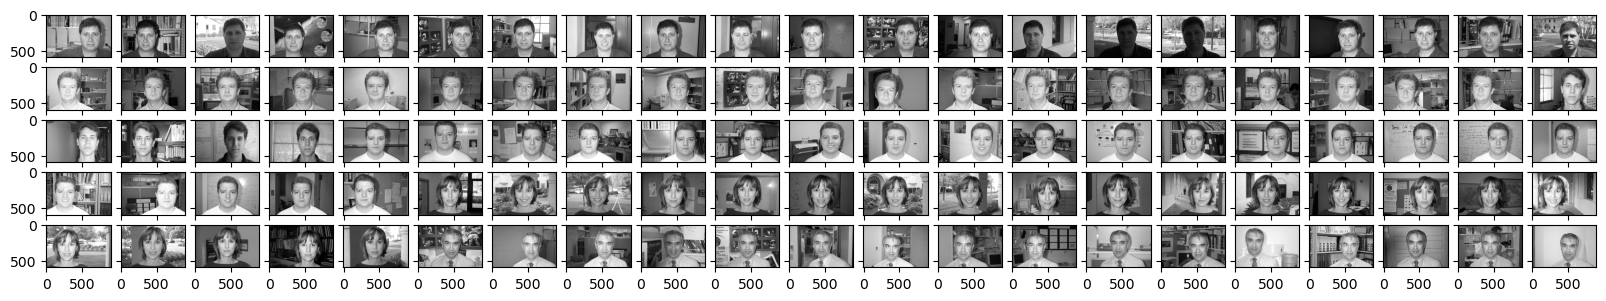

In [32]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [409]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [410]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

In [260]:
print(faces.images[...,0].shape)

(440, 47, 47)


### 2. Print statistics of data

In [414]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

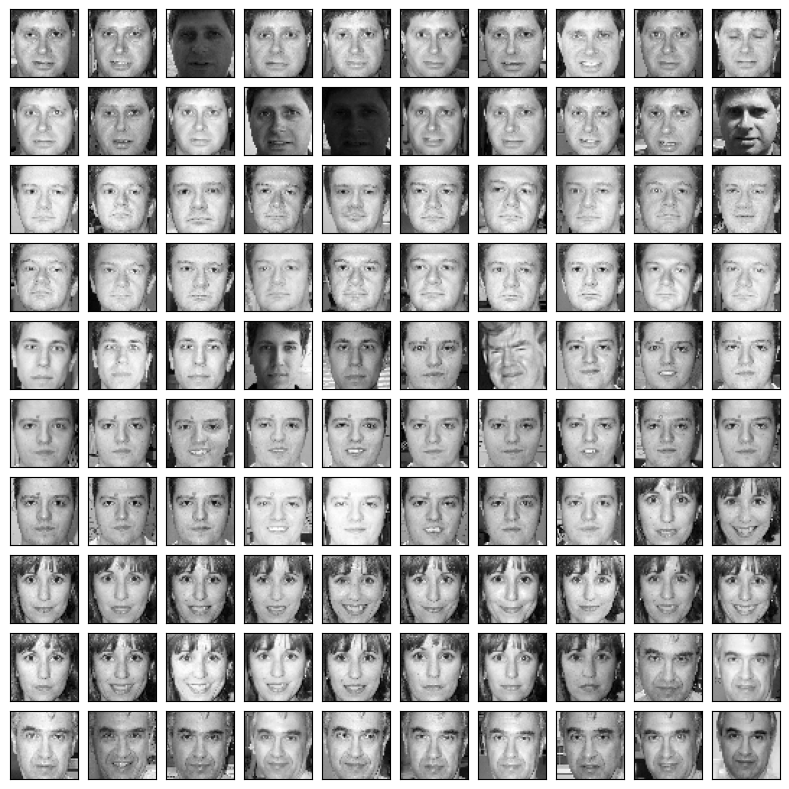

In [36]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [13]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.PCA
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [182]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

DESC = FeatureDescriptor.PCA

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    #embedded = X_pca
    pca_embedded = X_pca
    
    dist_metric_PCA = euclidean
    
def getPCAFeatureVectors():
    num_components = 35
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    #embedded = X_pca
    pca_embedded = X_pca
    
    dist_metric_PCA = euclidean

num_components 25


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [183]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

DESC = FeatureDescriptor.LDA

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    print("Num Components: ", num_components)
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    #embedded = X_lda
    lda_embedded = X_lda
    
    dist_metric_LDA = euclidean
    
def getLDAFeatureVectors():
    num_components = 35
    num_components = min(num_components, min(n_classes - 1, n_features))
    print("Num Components: ", num_components)
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    #embedded = X_lda
    lda_embedded = X_lda
    
    dist_metric_LDA = euclidean

Num Components:  25


### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [185]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

DESC = FeatureDescriptor.LBP

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    #embedded = desc.describe_list(faces.images[...,0])
    lbp_embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric_LBP = chisquare
    
# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

def getLBPFeatureVectors():
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    #embedded = desc.describe_list(faces.images[...,0])
    lbp_embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric_LBP = CHI2

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [415]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, 128)          894400      ['input_25[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 lambda_12 (Lambda)             (None, 1)            0           ['sequential_12[0][0]',   

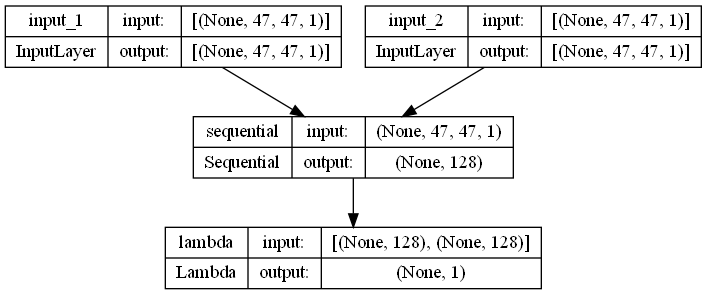

In [19]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [186]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

DESC = FeatureDescriptor.DL

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    #embedded = encoder(faces.images.astype(np.float32)).numpy()
    dl_embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric_DL = euclidean
    
def getDLFeatureVectors():
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    #embedded = encoder(faces.images.astype(np.float32)).numpy()
    dl_embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric_DL = euclidean

Epoch 1/10
38/38 - 6s - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.0054 - val_accuracy: 1.0000 - 6s/epoch - 150ms/step
Epoch 2/10
38/38 - 5s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 - 5s/epoch - 145ms/step
Epoch 3/10
38/38 - 5s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000 - 5s/epoch - 140ms/step
Epoch 4/10
38/38 - 5s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000 - 5s/epoch - 139ms/step
Epoch 5/10
38/38 - 5s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 - 5s/epoch - 141ms/step
Epoch 6/10
38/38 - 5s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 - 5s/epoch - 141ms/step
Epoch 7/10
38/38 - 5s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 - 5s/epoch - 143ms/step
Epoch 8/10
38/38 - 6s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000 - 6s/epoch - 150ms/step
Epoch 9/10
38/38 - 5s - 

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

### Q1 Computing the matching scores for embedded values

In [24]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def chi_square_distance(a, b):
    #return chisquare(a, b)[0]
    return CHI2(a, b)

In [25]:
print(DESC)

FeatureDescriptor.DL


In [ ]:
from scipy.spatial.distance import squareform

def compute_matching_scores(embedded):
    num_samples = len(embedded)
    matching_scores = np.zeros((num_samples, num_samples))

    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            distance = euclidean_distance(embedded[i], embedded[j])
            #distance = chi_square_distance(embedded[i], embedded[j])
            matching_scores[i, j] = distance
            matching_scores[j, i] = distance

    return matching_scores

pd.options.display.max_rows = 7
pd.options.display.max_columns = 7

pca_matching_scores = compute_matching_scores(pca_embedded)
lda_matching_scores = compute_matching_scores(lda_embedded)
lbp_matching_scores = compute_matching_scores(lbp_embedded)
dl_matching_scores  = compute_matching_scores(dl_embedded)

#matching_scores_df = pd.DataFrame(matching_scores)

print(pd.DataFrame(pca_matching_scores))
print(pd.DataFrame(lda_matching_scores))
print(pd.DataFrame(lbp_matching_scores))
print(pd.DataFrame(dl_matching_scores))

Output of PCA (n=25 components):

          0         1         2    ...       437       438       439
0    0.000000  3.669208  6.206336  ...  5.585034  6.836769  5.433579
1    3.669208  0.000000  5.110906  ...  4.643130  5.190178  4.598430
2    6.206336  5.110906  0.000000  ...  6.651359  6.820092  6.317218
..        ...       ...       ...  ...       ...       ...       ...
437  5.585034  4.643130  6.651359  ...  0.000000  3.246925  3.458317
438  6.836769  5.190178  6.820092  ...  3.246925  0.000000  3.964529
439  5.433579  4.598430  6.317218  ...  3.458317  3.964529  0.000000

[440 rows x 440 columns]

Output of LDA:

           0          1          2    ...        437        squareform        439
0     0.000000   6.255456   9.828133  ...  18.768981  16.740232  19.382462
1     6.255456   0.000000   8.985383  ...  18.172530  15.901287  18.289974
2     9.828133   8.985383   0.000000  ...  17.111925  15.270795  17.731951
..         ...        ...        ...  ...        ...        ...        ...
437  18.768981  18.172530  17.111925  ...   0.000000   6.148688   6.811352
438  16.740232  15.901287  15.270795  ...   6.148688   0.000000   5.784223
439  19.382462  18.289974  17.731951  ...   6.811352   5.784223   0.000000

[440 rows x 440 columns]

Output of LBP:

          0         1         2    ...       437       438       439
0    0.000000  4.817430  6.989416  ...  6.505435  6.073323  6.118790
1    4.817430  0.000000  7.213450  ...  6.600115  6.605394  6.651565
2    6.989416  7.213450  0.000000  ...  8.761857  7.983415  7.615998
..        ...       ...       ...  ...       ...       ...       ...
437  6.505435  6.600115  8.761857  ...  0.000000  5.198986  5.262652
438  6.073323  6.605394  7.983415  ...  5.198986  0.000000  5.318515
439  6.118790  6.651565  7.615998  ...  5.262652  5.318515  0.000000

[440 rows x 440 columns]

Output of Deep Learning:

          0         1         2    ...       437       438       439
0    0.000000  1.346578  1.720878  ...  1.602467  1.570857  1.560013
1    1.346578  0.000000  1.784709  ...  1.633466  1.654119  1.635354
2    1.720878  1.784709  0.000000  ...  1.946428  1.856337  1.787301
..        ...       ...       ...  ...       ...       ...       ...
437  1.602467  1.633466  1.946428  ...  0.000000  1.411483  1.467761
438  1.570857  1.654119  1.856337  ...  1.411483  0.000000  1.454028
439  1.560013  1.635354  1.787301  ...  1.467761  1.454028  0.000000

[440 rows x 440 columns]


## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

### Q2) F1 and Accuracy

We first write some helper functions to convert an array into binary labels
and make binary predictions ourselves.

In [133]:
def convertToBinary(arr, label):
    binary_array = np.zeros(len(arr))
    for i in range(0, len(arr)):
        if arr[i] == label:
            binary_array[i] = 1
    return binary_array

In [134]:
def generate_predictions(scores, threshold):
    
    # Normalize the scores
    min_val = min(scores)
    max_val = max(scores)
    normalized_scores = [(x - min_val) / (max_val - min_val) for x in scores]
    
    # Getting the predictions
    binary_predictions = [1 if normalized_scores[i] <= threshold else 0 for i in range(len(normalized_scores))]
    
    return binary_predictions

Now we can obtain the scores for different thresholds. We can do this for each 4 methods and compare them.

In [135]:
y_labels = faces["target"]

In [137]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = np.linspace(0, 1, 100)

#imageId = 0
num_classes = 26
y_labels = faces["target"]
num_samples = len(y_labels)

#images = [imageId if for imageId in range(0, len(faces["target"]))]

label_counts = np.zeros(num_classes)

f1_scores_for_classes  = np.zeros([num_classes, len(thresholds)])
acc_scores_for_classes = np.zeros([num_classes, len(thresholds)])

pca_f1_scores_all = np.zeros(len(thresholds))
pca_acc_scores_all = np.zeros(len(thresholds))
lda_f1_scores_all = np.zeros(len(thresholds))
lda_acc_scores_all = np.zeros(len(thresholds))
lbp_f1_scores_all = np.zeros(len(thresholds))
lbp_acc_scores_all = np.zeros(len(thresholds))
dl_f1_scores_all = np.zeros(len(thresholds))
dl_acc_scores_all = np.zeros(len(thresholds))

for imageId in range(0, num_samples):
    label = y_labels[imageId]
    pca_f1s = []
    pca_accuracies = []
    lda_f1s = []
    lda_accuracies = []
    lbp_f1s = []
    lbp_accuracies = []
    dl_f1s = []
    dl_accuracies = []
    
    for threshold in thresholds:
        true_labels = convertToBinary(y_labels, label)
        
        pca_binary_predictions = generate_predictions(pca_matching_scores[imageId], threshold)
        lda_binary_predictions = generate_predictions(lda_matching_scores[imageId], threshold)
        lbp_binary_predictions = generate_predictions(lbp_matching_scores[imageId], threshold)
        dl_binary_predictions = generate_predictions(dl_matching_scores[imageId], threshold)
        
        # Calculate the scores
        pca_f1s.append(f1_score(true_labels, pca_binary_predictions, average='binary'))
        pca_accuracies.append(accuracy_score(true_labels, pca_binary_predictions))
        lda_f1s.append(f1_score(true_labels, lda_binary_predictions, average='binary'))
        lda_accuracies.append(accuracy_score(true_labels, lda_binary_predictions))
        lbp_f1s.append(f1_score(true_labels, lbp_binary_predictions, average='binary'))
        lbp_accuracies.append(accuracy_score(true_labels, lbp_binary_predictions))
        dl_f1s.append(f1_score(true_labels, dl_binary_predictions, average='binary'))
        dl_accuracies.append(accuracy_score(true_labels, dl_binary_predictions))
        
        #f1s.append(f1)
        #accuracies.append(accuracy)
        
        
    #label_counts[label] += 1
    #f1_scores_for_classes[label]  += f1s
    #acc_scores_for_classes[label] += accuracies
           
    pca_f1_scores_all += pca_f1s
    pca_acc_scores_all += pca_accuracies
    lda_f1_scores_all += lda_f1s
    lda_acc_scores_all += lda_accuracies
    lbp_f1_scores_all += lbp_f1s
    lbp_acc_scores_all += lbp_accuracies
    dl_f1_scores_all += dl_f1s
    dl_acc_scores_all += dl_accuracies
    

#for i, label_count in enumerate(label_counts):
#    f1_scores_for_classes[i]  /= label_count
#    acc_scores_for_classes[i] /= label_count

pca_f1_scores_all /= num_samples
pca_acc_scores_all /= num_samples
lda_f1_scores_all /= num_samples
lda_acc_scores_all /= num_samples
lbp_f1_scores_all /= num_samples
lbp_acc_scores_all /= num_samples
dl_f1_scores_all /= num_samples
dl_acc_scores_all /= num_samples
     
# Print the best thresholds
best_threshold_f1_pca = thresholds[np.argmax(pca_f1_scores_all)]
best_threshold_acc_pca = thresholds[np.argmax(pca_acc_scores_all)]
best_threshold_f1_lda = thresholds[np.argmax(lda_f1_scores_all)]
best_threshold_acc_lda = thresholds[np.argmax(lda_acc_scores_all)]
best_threshold_f1_lbp = thresholds[np.argmax(lbp_f1_scores_all)]
best_threshold_acc_lbp = thresholds[np.argmax(lbp_acc_scores_all)]
best_threshold_f1_dl = thresholds[np.argmax(dl_f1_scores_all)]
best_threshold_acc_dl = thresholds[np.argmax(dl_acc_scores_all)]

print("PCA: Best threshold according to F1 scores  is: ", thresholds[np.argmax(pca_f1_scores_all)])
print("PCA: Best threshold according to Accuracies is: ", thresholds[np.argmax(pca_acc_scores_all)])
print("LDA: Best threshold according to F1 scores  is: ", thresholds[np.argmax(lda_f1_scores_all)])
print("LDA: Best threshold according to Accuracies is: ", thresholds[np.argmax(lda_acc_scores_all)])
print("LBP: Best threshold according to F1 scores  is: ", thresholds[np.argmax(lbp_f1_scores_all)])
print("LBP: Best threshold according to Accuracies is: ", thresholds[np.argmax(lbp_acc_scores_all)])
print("DL: Best threshold according to F1 scores  is: ", thresholds[np.argmax(dl_f1_scores_all)])
print("DL: Best threshold according to Accuracies is: ", thresholds[np.argmax(dl_acc_scores_all)])

PCA: Best threshold according to F1 scores  is:  0.43434343434343436
PCA: Best threshold according to Accuracies is:  0.4040404040404041
LDA: Best threshold according to F1 scores  is:  0.38383838383838387
LDA: Best threshold according to Accuracies is:  0.36363636363636365
LBP: Best threshold according to F1 scores  is:  0.6464646464646465
LBP: Best threshold according to Accuracies is:  0.5656565656565657
DL: Best threshold according to F1 scores  is:  0.17171717171717174
DL: Best threshold according to Accuracies is:  0.16161616161616163


We have now obtained the scores for different classes the range of thresholds. With this information, we can select a threshold for a specific class that we want to identify or we can select the threshold value that performs the best overall.

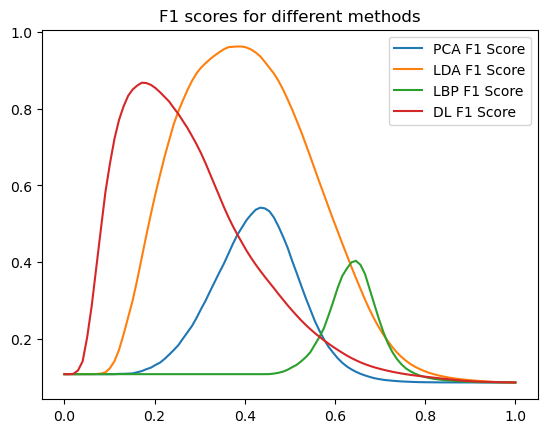

In [138]:
plt.plot(thresholds, pca_f1_scores_all, label="PCA F1 Score")
plt.plot(thresholds, lda_f1_scores_all, label="LDA F1 Score")
plt.plot(thresholds, lbp_f1_scores_all, label="LBP F1 Score")
plt.plot(thresholds, dl_f1_scores_all, label="DL F1 Score")

plt.title("F1 scores for different methods")

plt.legend()
plt.show()

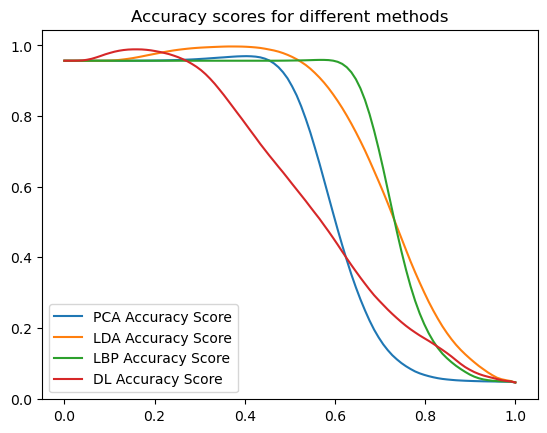

In [139]:
plt.plot(thresholds, pca_acc_scores_all, label="PCA Accuracy Score")
plt.plot(thresholds, lda_acc_scores_all, label="LDA Accuracy Score")
plt.plot(thresholds, lbp_acc_scores_all, label="LBP Accuracy Score")
plt.plot(thresholds, dl_acc_scores_all, label="DL Accuracy Score")

plt.title("Accuracy scores for different methods")

plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

#### Q3 Genuine and Impostor Scores

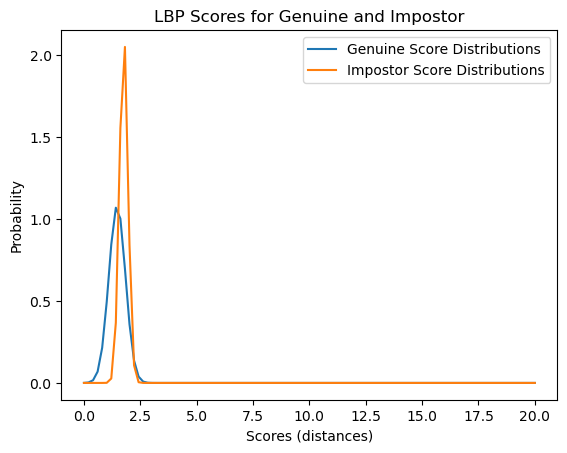

In [210]:
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.metrics import auc
from scipy.integrate import quad

# Step 1: Calculate genuine and impostor scores
genuine_scores = []
impostor_scores = []

y_labels = faces["target"]

for i in range(len(y_labels)):
    for j in range(len(y_labels)):
        if y_labels[i] == y_labels[j]:
            genuine_scores.append(lbp_matching_scores[i, j])
        else:
            impostor_scores.append(lbp_matching_scores[i, j])

# Step 2: Plot genuine and impostor scores
#plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores')
#plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores')

x_values = np.linspace(0.0, 20.0, num=100)

g_mu = np.mean(genuine_scores)
g_variance = np.var(genuine_scores)
g_sigma = np.sqrt(g_variance)

g_y_values = stats.norm.pdf(x_values, g_mu, g_sigma)

i_mu = np.mean(impostor_scores)
i_variance = np.var(impostor_scores)
i_sigma = np.sqrt(i_variance)

i_y_values = stats.norm.pdf(x_values, i_mu, i_sigma)

plt.plot(x_values, g_y_values, label='Genuine Score Distributions')
plt.plot(x_values, i_y_values, label='Impostor Score Distributions')
plt.xlabel('Scores (distances)')
plt.ylabel('Probability')
plt.title('LBP Scores for Genuine and Impostor')
plt.legend()
plt.show()

In [ ]:
print(dl_matching_scores)

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

#### Q4 Thresholds and EER

In [153]:
# I recalculate the distances and the binary truth labels as a single array to calculate the remaining metrics easier

from scipy.spatial.distance import pdist

pca_pdists = pdist(pca_embedded, dist_metric_PCA)
lda_pdists = pdist(lda_embedded, dist_metric_LDA)
lbp_pdists = pdist(lbp_embedded, CHI2)
dl_pdists = pdist(dl_embedded, dist_metric_DL)

In [154]:
def generate_true_values():
    array = np.zeros(96580)
    for i in range(0, 440):
        for j in range(i+1, 440):
            array[440 * i + j - ((i + 2) * (i + 1)) // 2] = (faces["target"][i] == faces["target"][j])
    return array

In [157]:
array_of_true_labels = generate_true_values()
print(len(array_of_true_labels))

96580


In [161]:
inverse_pca_pdists = 1/pca_pdists
inverse_lda_pdists = 1/lda_pdists
inverse_lbp_pdists = 1/lbp_pdists
inverse_dl_pdists =  1/dl_pdists

In [164]:
from sklearn import metrics

fpr_pca, tpr_pca, thresholds_pca = metrics.roc_curve(array_of_true_labels, inverse_pca_pdists)
fpr_lda, tpr_lda, thresholds_lda = metrics.roc_curve(array_of_true_labels, inverse_lda_pdists)
fpr_lbp, tpr_lbp, thresholds_lbp = metrics.roc_curve(array_of_true_labels, inverse_lbp_pdists)
fpr_dl, tpr_dl, thresholds_dl = metrics.roc_curve(array_of_true_labels, inverse_dl_pdists)

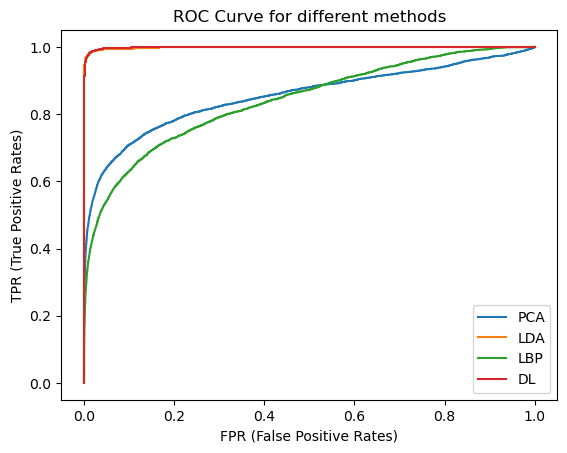

In [211]:
# Plot the ROC curve (TPR against the FPR for different threshold values)
plt.plot(fpr_pca, tpr_pca, label="PCA")
plt.plot(fpr_lda, tpr_lda, label="LDA")
plt.plot(fpr_lbp, tpr_lbp, label="LBP")
plt.plot(fpr_dl, tpr_dl, label="DL")

plt.title("ROC Curve for different methods")
plt.legend()

plt.xlabel('FPR (False Positive Rates)')
plt.ylabel('TPR (True Positive Rates)')

plt.show()

EER for PCA is 0.21164355785893613
EER for LDA is 0.016200941838526606
EER for LBP is 0.24308353243191883
EER for DL is 0.015487388451433472


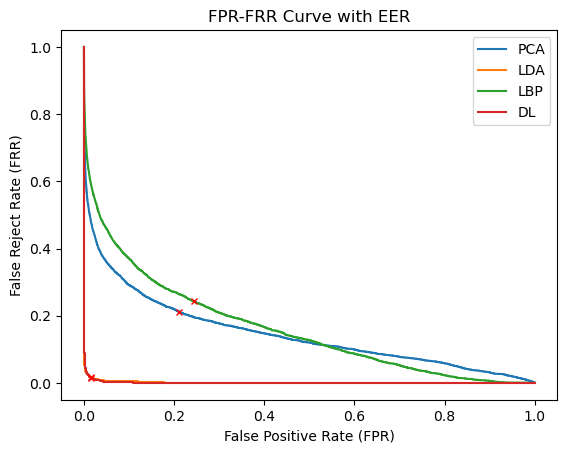

In [175]:
# Calculate and Plot the EER

def plot_eer(thresholds, fpr, tpr, name):
    min_distance = 99999
    threshold = 0
    index = 0

    for i, thresh in enumerate(thresholds):
        distance = abs(fpr[i] - (1-tpr[i]))
        if distance < min_distance:
            min_distance = distance
            threshold = thresh
            index = i
    eer = (fpr[index] + (1-tpr[index])) / 2

    plt.plot(fpr, 1-tpr, label=name)
    plt.plot(eer, eer, marker='x', markersize=5, color='red')
    
    print("EER for", name, "is", eer)
    
plot_eer(thresholds_pca, fpr_pca, tpr_pca, "PCA") 
plot_eer(thresholds_lda, fpr_lda, tpr_lda, "LDA")    
plot_eer(thresholds_lbp, fpr_lbp, tpr_lbp, "LBP") 
plot_eer(thresholds_dl, fpr_dl, tpr_dl, "DL")    

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Reject Rate (FRR)')
plt.title('FPR-FRR Curve with EER')
plt.legend()
plt.show()


In [176]:
# Calculate the average precision scores
from sklearn.metrics import average_precision_score

print("Precision PCA: ", average_precision_score(array_of_true_labels, inverse_pca_pdists))
print("Precision LDA: ", average_precision_score(array_of_true_labels, inverse_lda_pdists))
print("Precision LBP: ", average_precision_score(array_of_true_labels, inverse_lbp_pdists))
print("Precision DL: ", average_precision_score(array_of_true_labels, inverse_dl_pdists))


Precision PCA:  0.5692533518735872
Precision LDA:  0.9853387732625174
Precision LBP:  0.46043081437238187
Precision DL:  0.9851673831022401


#### Precision and Recall Curves

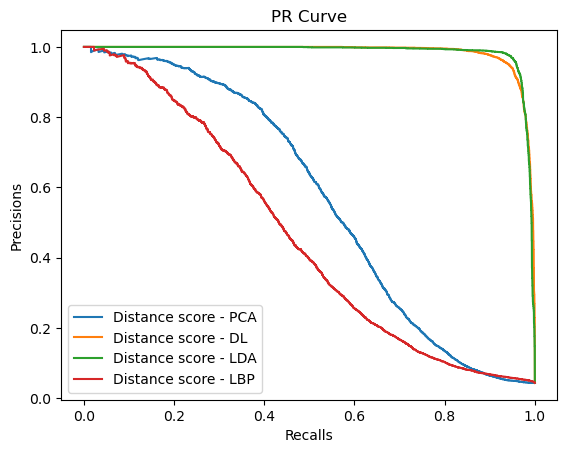

In [213]:
from sklearn.metrics import precision_recall_curve
  
#label = y_labels[imageId]
#true_labels = convertToBinary(y_labels, label)
    
precision_pca, recall_pca, _ = precision_recall_curve(array_of_true_labels, inverse_pca_pdists)
precision_lda, recall_lda, _ = precision_recall_curve(array_of_true_labels, inverse_lda_pdists)
precision_lbp, recall_lbp, _ = precision_recall_curve(array_of_true_labels, inverse_lbp_pdists)
precision_dl, recall_dl, _ = precision_recall_curve(array_of_true_labels, inverse_dl_pdists)


plt.plot(recall_pca, precision_pca, label='Distance score - PCA')
plt.plot(recall_dl, precision_dl, label='Distance score - DL')
plt.plot(recall_lda, precision_lda, label='Distance score - LDA')
plt.plot(recall_lbp, precision_lbp, label='Distance score - LBP')


plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.title("PR Curve")
plt.legend()
plt.show()
        

In [216]:
# Calculate the AUC for PR
from sklearn.metrics import auc

area_pca = auc(recall_pca, precision_pca)
area_lda = auc(recall_lda, precision_lda)
area_lbp = auc(recall_lbp, precision_lbp)
area_dl  = auc(recall_dl, precision_dl)

print("AUC PCA:", area_pca)
print("AUC LDA:", area_lda)
print("AUC LBP:", area_lbp)
print("AUC DL:" , area_dl)

AUC PCA: 0.5692213509801451
AUC LDA: 0.9853376104458218
AUC LBP: 0.4603884886137576
AUC DL: 0.985166031364752


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [102]:
y_labels[397]

24

In [108]:
def compute_cmc(true_labels, scores):
    image_ids = [0, 20, 40, 45, 68, 89, 112, 132, 137, 158, 165, 170, 175, 195, 216,
                 241, 263, 268, 288, 307, 336, 356, 376, 392, 398, 420]
    
    num_samples = len(true_labels)
    num_ranks = 50
    # Sort the scores and get the sorted indices for each sample
    sorted_indices = np.argsort(scores, axis=1)

    # Initialize the CMC curve
    cmc_curve = np.zeros((num_ranks,))

    # Iterate over each sample
    for i in image_ids:
        true_label = true_labels[i]

        # Check if the true label is within the top ranks
        matches = np.where(true_labels[sorted_indices[i]] == true_label)[0]
        #print(matches)

        # Increment the CMC curve for each rank
        for j in matches:
            if j < num_ranks:
                cmc_curve[j:] += 1

    # Normalize the CMC curve
    cmc_curve /= num_samples
    
    #print(cmc_curve.shape)
    #print(cmc_curve)

    return cmc_curve

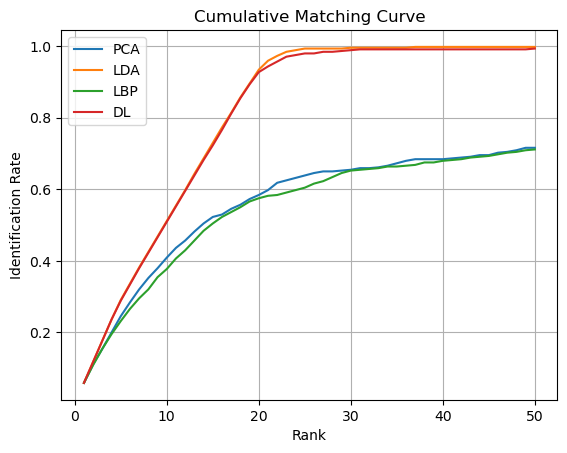

In [111]:
pca_cmc_curve = compute_cmc(y_labels, pca_matching_scores)
lda_cmc_curve = compute_cmc(y_labels, lda_matching_scores)
lbp_cmc_curve = compute_cmc(y_labels, lbp_matching_scores)
dl_cmc_curve  = compute_cmc(y_labels, dl_matching_scores)

# Plot the Cumulative Matching Curve
ranks = np.arange(1, len(cmc_curve) + 1)

plt.plot(ranks, pca_cmc_curve, label='PCA')
plt.plot(ranks, lda_cmc_curve, label='LDA')
plt.plot(ranks, lbp_cmc_curve, label='LBP')
plt.plot(ranks, dl_cmc_curve,  label='DL')

plt.xlabel('Rank')
plt.ylabel('Identification Rate')
plt.title('Cumulative Matching Curve')

plt.legend()
plt.grid(True)
plt.show()

## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.) - Partially Done
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.) - Partially Done
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

In [383]:
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces

# Read Olivetti Faces

from numpy.random import RandomState

rng = RandomState(0)

#data = fetch_olivetti_faces()
data = fetch_lfw_people(min_faces_per_person=100)

#faces, targets = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
faces, targets = fetch_lfw_people(return_X_y=True, min_faces_per_person=100)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

np.set_printoptions(edgeitems=15)
print("Dataset consists of %d faces" % n_samples)
print(n_features)
print(data.target)

Dataset consists of 1140 faces
2914
[2 3 1 4 1 0 2 0 2 1 3 0 2 2 4 ... 2 1 2 0 2 4 0 1 2 0 4 4 4 2 4]


In [386]:
## PCA

# For LFW Subset (Comment this out when not using LFW)
num_components = 25

num_components = min(num_components, min(n_samples, n_features))
print("num_components {n}".format(n=num_components))
desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces_centered.data)
X_pca = desc.transform(faces_centered.data)
#embedded = X_pca
pca_embedded = X_pca

dist_metric_PCA = euclidean

num_components 25


In [389]:
## LDA

# For LFW Subset (Comment this out when not using LFW)
num_components = 4

num_components = min(num_components, min(n_classes - 1, n_features))
print(num_components)
desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces_centered, targets)
X_lda = desc.fit_transform(faces_centered, targets)
lda_embedded = X_lda

dist_metric_lda = euclidean

4


In [390]:
## LBP

desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
lbp_embedded = desc.describe_list(data.images)
dist_metric_lbp = CHI2

In [391]:
## DL

n_samples, h, w = data.images.shape
n_channels = 1
imshape = (h, w, n_channels)
#imshape = (w, h, n_channels)
print(n_samples)
print(imshape)

1140
(62, 47, 1)


In [392]:
images_with_channel = np.expand_dims(data.images, axis=-1)

#images_with_channel = np.transpose(images_with_channel, (0,2,1,3))

print(images_with_channel.shape)
print(data.images.shape)
print(faces.shape)
print(targets.shape)

(1140, 62, 47, 1)
(1140, 62, 47)
(1140, 2914)
(1140,)


In [393]:
import localmodules.siamese as siamese

encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 62, 47, 1)]  0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 62, 47, 1)]  0           []                               
                                                                                                  
 sequential_10 (Sequential)     (None, 128)          1222080     ['input_21[0][0]',               
                                                                  'input_22[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 1)            0           ['sequential_10[0][0]',   

In [ ]:
## DL

#x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(images_with_channel, targets))
x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(images_with_channel, targets))
rms = Adam()
model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy],
    run_eagerly=True)

epochs = 30

model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
          validation_split=0.2,
          batch_size=32, verbose=2, epochs=epochs)

test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
test_acc = accuracy_score(y_test, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))
dl_embedded = encoder(data.images.astype(np.float32)).numpy()

dist_metric_dl = euclidean

In [395]:
print(pca_embedded.shape)
print(lda_embedded.shape)
print(lbp_embedded.shape)
print(dl_embedded.shape)

(1140, 25)
(1140, 4)
(1140, 490)
(400, 128)


In [ ]:
olivetti_pca_pdists = pdist(pca_embedded, euclidean)
olivetti_lda_pdists = pdist(lda_embedded, euclidean)
olivetti_lbp_pdists = pdist(lbp_embedded, CHI2)
olivetti_dl_pdists = pdist(dl_embedded, euclidean)
print(len(olivetti_pca_pdists))
print(len(olivetti_lda_pdists))
print(len(olivetti_lbp_pdists))
print(len(olivetti_dl_pdists))

In [398]:
lfw_pca_pdists = pdist(pca_embedded, euclidean)
lfw_lda_pdists = pdist(lda_embedded, euclidean)
lfw_lbp_pdists = pdist(lbp_embedded, CHI2)
#lfw_dl_pdists = pdist(dl_embedded, euclidean)
print(len(lfw_pca_pdists))
print(len(lfw_lda_pdists))
print(len(lfw_lbp_pdists))
#print(len(lfw_dl_pdists))

649230
649230
649230


In [397]:
def generate_true_values(array_length, num_of_samples):
    array = np.zeros(array_length)
    for i in range(0, num_of_samples):
        for j in range(i+1, num_of_samples):
            array[num_of_samples * i + j - ((i + 2) * (i + 1)) // 2] = (targets[i] == targets[j])
    return array

true_labels_olivetti = generate_true_values(79800, 400)
true_labels_lfw = generate_true_values(649230, 1140)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = np.linspace(0, 1, 100)

f1s_olivetti_pca = []
accuracies_olivetti_pca = []
f1s_olivetti_lda = []
accuracies_olivetti_lda = []
f1s_olivetti_lbp = []
accuracies_lfw_lbp = []
f1s_olivetti_dl = []
accuracies_olivetti_dl = []

for threshold in thresholds:
    binary_predictions_olivetti_pca = generate_predictions(olivetti_pca_pdists, threshold)
    binary_predictions_olivetti_lda = generate_predictions(olivetti_lda_pdists, threshold)
    binary_predictions_olivetti_lbp = generate_predictions(olivetti_lbp_pdists, threshold)
    binary_predictions_olivetti_dl = generate_predictions(olivetti_dl_pdists , threshold)
    
    f1s_olivetti_pca.append(f1_score(true_labels_olivetti, binary_predictions_olivetti_pca, average='binary'))
    accuracies_olivetti_pca.append(accuracy_score(true_labels_olivetti, binary_predictions_olivetti_pca))
    f1s_olivetti_lda.append(f1_score(true_labels_olivetti, binary_predictions_olivetti_lda, average='binary'))
    accuracies_olivetti_lda.append(accuracy_score(true_labels_olivetti, binary_predictions_olivetti_lda))
    f1s_olivetti_lbp.append(f1_score(true_labels_olivetti, binary_predictions_olivetti_lbp, average='binary'))
    accuracies_olivetti_lbp.append(accuracy_score(true_labels_olivetti, binary_predictions_olivetti_lbp))
    f1s_olivetti_dl.append(f1_score(true_labels_olivetti, binary_predictions_olivetti_dl, average='binary'))
    accuracies_olivetti_dl.append(accuracy_score(true_labels_olivetti, binary_predictions_olivetti_dl))
    

plt.plot(thresholds, f1s_olivetti_pca, label="PCA")
plt.plot(thresholds, f1s_olivetti_lda, label="LDA")
plt.plot(thresholds, f1s_olivetti_lbp, label="LBP")
plt.plot(thresholds, f1s_olivetti_dl,  label="DL")

plt.title("F1 scores for Olivetti Dataset")

plt.legend()
plt.show()

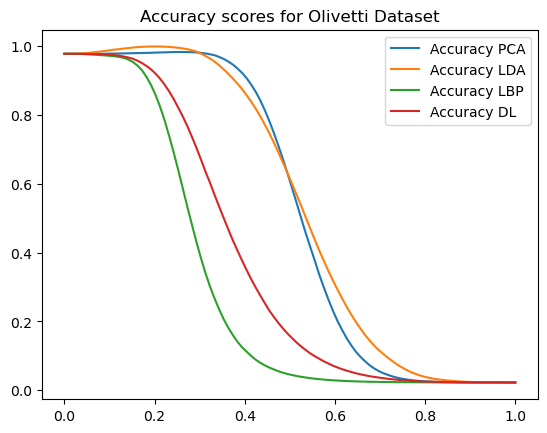

In [297]:
plt.plot(thresholds, accuracies_olivetti_pca, label="Accuracy PCA")
plt.plot(thresholds, accuracies_olivetti_lda, label="Accuracy LDA")
plt.plot(thresholds, accuracies_olivetti_lbp, label="Accuracy LBP")
plt.plot(thresholds, accuracies_olivetti_dl, label="Accuracy DL")

plt.title("Accuracy scores for Olivetti Dataset")

plt.legend()
plt.show()

NameError: name 'f1s_lfw_dl' is not defined

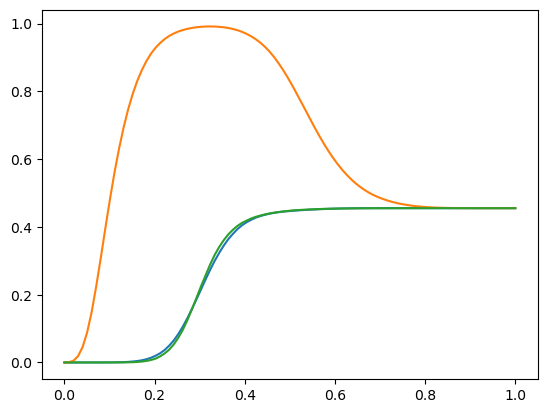

In [399]:
from sklearn.metrics import f1_score, accuracy_score

thresholds = np.linspace(0, 1, 100)

f1s_lfw_pca = []
accuracies_lfw_pca = []
f1s_lfw_lda = []
accuracies_lfw_lda = []
f1s_lfw_lbp = []
accuracies_lfw_lbp = []
#f1s_lfw_dl = []
#accuracies_lfw_dl = []

for threshold in thresholds:
    binary_predictions_lfw_pca = generate_predictions(lfw_pca_pdists, threshold)
    binary_predictions_lfw_lda = generate_predictions(lfw_lda_pdists, threshold)
    binary_predictions_lfw_lbp = generate_predictions(lfw_lbp_pdists, threshold)
    #binary_predictions_lfw_dl = generate_predictions(lfw_dl_pdists , threshold)
    
    f1s_lfw_pca.append(f1_score(true_labels_lfw, binary_predictions_lfw_pca, average='binary'))
    accuracies_lfw_pca.append(accuracy_score(true_labels_lfw, binary_predictions_lfw_pca))
    f1s_lfw_lda.append(f1_score(true_labels_lfw, binary_predictions_lfw_lda, average='binary'))
    accuracies_lfw_lda.append(accuracy_score(true_labels_lfw, binary_predictions_lfw_lda))
    f1s_lfw_lbp.append(f1_score(true_labels_lfw, binary_predictions_lfw_lbp, average='binary'))
    accuracies_lfw_lbp.append(accuracy_score(true_labels_lfw, binary_predictions_lfw_lbp))
    #f1s_lfw_dl.append(f1_score(true_labels_lfw, binary_predictions_lfw_dl, average='binary'))
    #accuracies_lfw_dl.append(accuracy_score(true_labels_lfw, binary_predictions_lfw_dl))
    

plt.plot(thresholds, f1s_lfw_pca, label="PCA")
plt.plot(thresholds, f1s_lfw_lda, label="LDA")
plt.plot(thresholds, f1s_lfw_lbp, label="LBP")
plt.plot(thresholds, f1s_lfw_dl,  label="DL")

plt.title("F1 scores for lfw Dataset")

plt.legend()
plt.show()

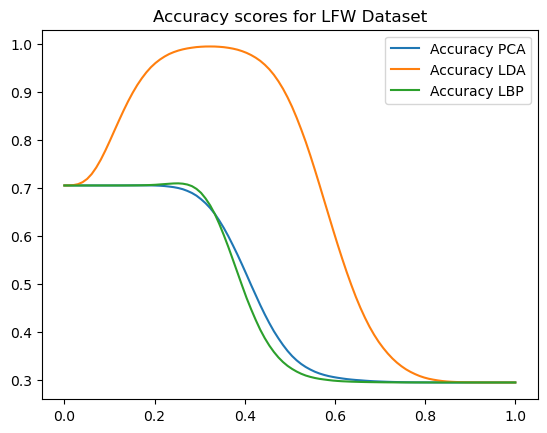

In [402]:
plt.plot(thresholds, accuracies_lfw_pca, label="Accuracy PCA")
plt.plot(thresholds, accuracies_lfw_lda, label="Accuracy LDA")
plt.plot(thresholds, accuracies_lfw_lbp, label="Accuracy LBP")
#plt.plot(thresholds, accuracies_lfw_dl, label="Accuracy DL")

plt.title("Accuracy scores for LFW Dataset")

plt.legend()
plt.show()

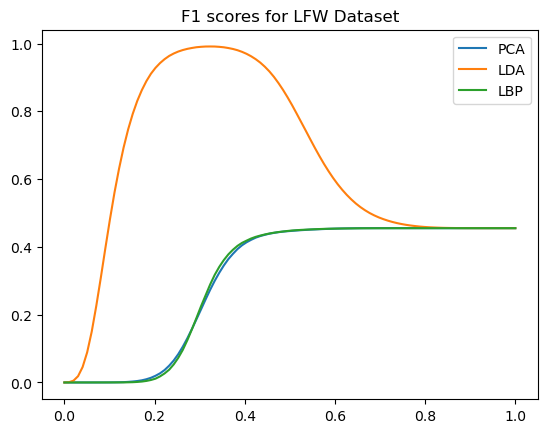

In [403]:
plt.plot(thresholds, f1s_lfw_pca, label="PCA")
plt.plot(thresholds, f1s_lfw_lda, label="LDA")
plt.plot(thresholds, f1s_lfw_lbp, label="LBP")

plt.title("F1 scores for LFW Dataset")

plt.legend()
plt.show()

### Compare different Face Detectors

(592, 896)


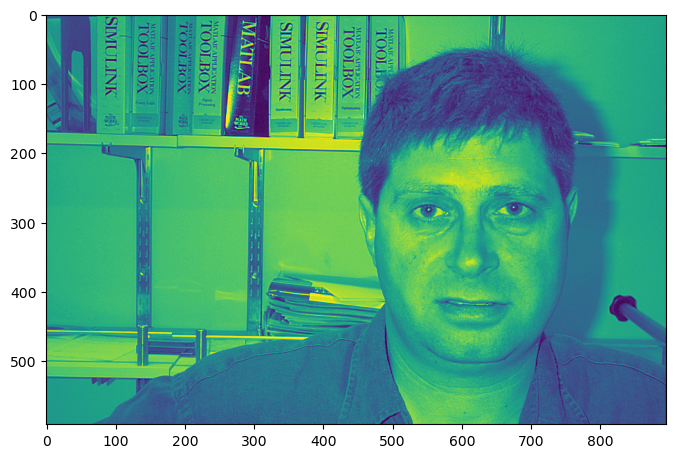

In [21]:
# Crop picture for it to be 1:2 aspect ratio

gray = cv2.imread('CalTechFacesDirs\person_001\image_0001.jpg', 0)
print(gray.shape)
im = np.float32(gray) / 255.0
# Calculate gradient 
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
plt.figure(figsize=(8,8))
plt.imshow(gray)
plt.show()

In [19]:
ground_truth_coordinates[0][1]

37

IOU for MMOD is  0.35344827586206895
IOU for HOG is  0.42120572366877784


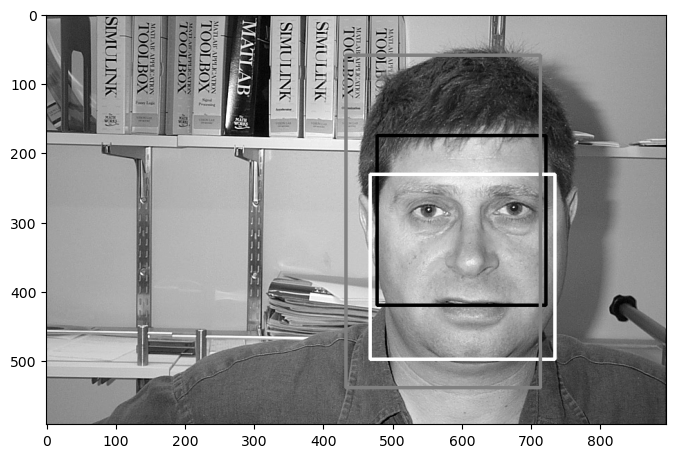

In [22]:
(x1,y1,x2,y2) = mmod_face_detector(gray)
cv2.rectangle(gray, (x1, y1), (x2, y2), (0, 0, 0), 3)

print("IOU for MMOD is ", calculate_iou(ground_truth_coordinates[0], (x1,y1,x2,y2)))

(x1,y1,x2,y2) = hog_face_detector(gray)
cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 255, 255), 3)

print("IOU for HOG is ", calculate_iou(ground_truth_coordinates[0], (x1,y1,x2,y2)))
      
cv2.rectangle(gray, (ground_truth_coordinates[0][0], ground_truth_coordinates[1][1]), 
              (ground_truth_coordinates[2][2], ground_truth_coordinates[3][3]), (128, 128, 128), 3)
      
plt.figure(figsize=(8,8))
plt.imshow(gray, cmap='gray')
plt.show()

In [4]:
import dlib
from imutils import face_utils

def hog_face_detector(param_image):
    # HOG face detector
    face_detect = dlib.get_frontal_face_detector()
    rects = face_detect(param_image, 1)
    if not rects:
        return (0,0,0,0)
    (x, y, w, h) = face_utils.rect_to_bb(rects[0])
    return (x, y, x+w, y+h)

In [5]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

def mmod_face_detector(param_image):
    rects = dnnFaceDetector(param_image, 1)
    if not rects:
        return (0,0,0,0)
    rect = rects[0]
    x1 = rect.rect.left()
    y1 = rect.rect.top()
    x2 = rect.rect.right()
    y2 = rect.rect.bottom()
    return (x1,y1,x2,y2)

In [ ]:
(x1,y1,x2,y2) = mmod_face_detector(gray)
cv2.rectangle(gray, (x1, y1), (x2, y2), (255, 255, 255), 3)
plt.figure(figsize=(8,8))
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
import scipy
import scipy.io

coordinates_data = scipy.io.loadmat('CalTechFacesDirs/ImageData.mat')
coordinates = coordinates_data['SubDir_Data']
coordinates = np.asarray(coordinates, dtype='int')

ground_truth_coordinates = []
for i in range(len(data['images'])):
    x1,y2,x3,y3,x2,y1,x4,y4 = coordinates[:,i]
    ground_truth_coordinates.append((x1,y1,x2,y2))

print(ground_truth_coordinates)

In [8]:
def calculate_iou(gt_box, pred_box):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(gt_box[0], pred_box[0])
    y1 = max(gt_box[1], pred_box[1])
    x2 = min(gt_box[2], pred_box[2])
    y2 = min(gt_box[3], pred_box[3])

    # Calculate the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the area of both bounding boxes
    gt_box_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_box_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

    # Calculate the Union area
    union_area = gt_box_area + pred_box_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

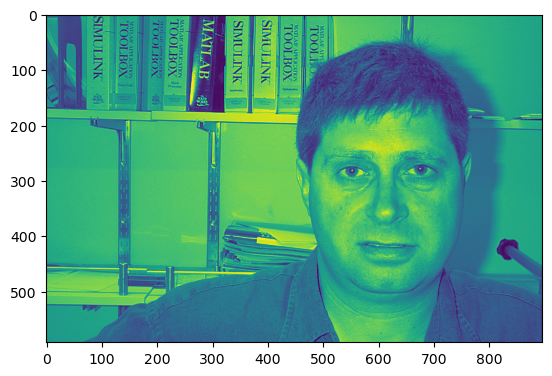

In [9]:
plt.imshow(data['images'][0])

In [11]:
iou_hog=[]
iou_mmod=[]

for i, image in enumerate(data['images']):
    (x1,y1,x2,y2) = hog_face_detector(image)
    print((x1,y1,x2,y2))
    print(ground_truth_coordinates[i])
    print(calculate_iou(ground_truth_coordinates[i],(x1,y1,x2,y2)))
    iou_hog.append(calculate_iou(ground_truth_coordinates[i],(x1,y1,x2,y2)))
    (x1,y1,x2,y2) = mmod_face_detector(image)
    iou_mmod.append(calculate_iou(ground_truth_coordinates[i],(x1,y1,x2,y2)))

print(np.array(iou_hog))
print(np.array(iou_mmod))

plt.plot(range(0,len(faces['images'])), iou_hog,  label="HOG")
plt.plot(range(0,len(faces['images'])), iou_mmod, label="MMOD")

plt.title("IOU scores for HOG and MMOD Face Detectors")

plt.legend()
plt.show()

(455, 206, 776, 527)
(433, 37, 780, 526)
0.6050151602065066
(200, 231, 468, 498)
(189, 59, 534, 522)
0.4490482359976081
(409, 201, 676, 468)
(354, 47, 714, 508)
0.43064599297286277
(200, 260, 468, 528)
(172, 109, 505, 539)
0.5026675187907248
(438, 231, 706, 498)
(414, 66, 749, 514)
0.47786085480962986


KeyboardInterrupt: 

### Change the Parameters of the Siamese Network

In [441]:
"""
import tensorflow as tf
from tensorflow.keras import backend as K

def triplet_loss(y_pred, y_true, alpha=0.2):
    anchor = y_pred[:, 0]
    positive = y_pred[:, 1]

    # Compute the Euclidean distance
    distance = K.sum(K.square(anchor - positive), axis=-1)

    # Compute the triplet loss
    loss = K.maximum(distance - alpha, 0.0)

    return K.mean(loss)
"""

In [ ]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import tensorflow as tf

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
        #loss=siamese.contrastive_loss,
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_dl_binary = encoder(faces.images.astype(np.float32)).numpy()
    #embedded_dl_contrastive = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric_dl = euclidean

In [422]:
np.printoptions(edgeitems=3)
dl_pdists_binary = pdist(embedded_dl_binary, dist_metric_dl)
print(dl_pdists_binary)
dl_pdists_contrastive = pdist(embedded_dl_contrastive, dist_metric_dl)
print(dl_pdists_contrastive)

[232.29192887 253.32893077  22.80645632  59.04536427  45.13351831
  79.67549556 121.24904296  45.00279782  65.9280826   43.84538642
  29.68156749  57.89682188 269.94358675 452.81557592  72.3216218  ...
  31.58288185  62.56911635  33.57557475  18.34872057  49.16325468
  48.93919423  40.77981254  32.34279829  58.97847752  49.47263999
  60.84518589  52.12356765  34.55286295  25.67179213  45.27135919]
[ 36.30218858  68.75881067  16.54730519  19.95902697  27.02891869
  28.76615309  42.28023207  22.83522185  23.60306135  20.33463729
  38.28641899  24.82375574 116.14302065 143.42852185  43.17133856 ...
  21.57243143  21.69464171  28.40041948  17.98927108  15.99578818
  15.3554206   24.18355853  30.58915821  29.10511965  12.32486207
  21.22059124  20.36917403  20.2445152   20.51590172   3.73995866]


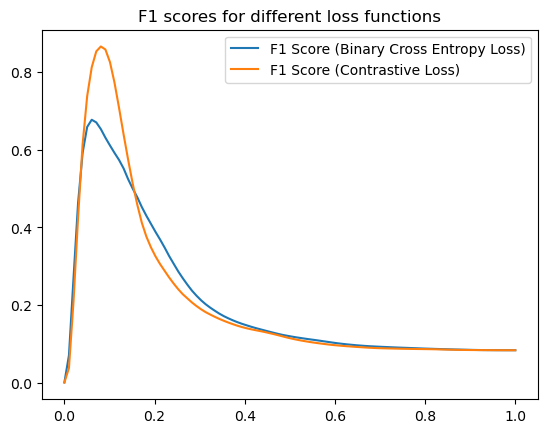

In [435]:
thresholds = np.linspace(0, 1, 100)

f1s_binary = []
accuracies_binary = []
f1s_contrastive = []
accuracies_contrastive = []

true_labels = generate_true_values(96580, 440)
for threshold in thresholds:
    binary_predictions_binary = generate_predictions(dl_pdists_binary, threshold)
    binary_predictions_contrastive = generate_predictions(dl_pdists_contrastive, threshold)
    
    f1s_binary.append(f1_score(true_labels, binary_predictions_binary, average='binary'))
    f1s_contrastive.append(f1_score(true_labels, binary_predictions_contrastive, average='binary'))
    
    accuracies_binary.append(accuracy_score(true_labels, binary_predictions_binary))
    accuracies_contrastive.append(accuracy_score(true_labels, binary_predictions_contrastive))
    
    
plt.plot(thresholds, f1s_binary, label="F1 Score (Binary Cross Entropy Loss)")
plt.plot(thresholds, f1s_contrastive, label="F1 Score (Contrastive Loss)")

plt.title("F1 scores for different loss functions")

plt.legend()
plt.show()

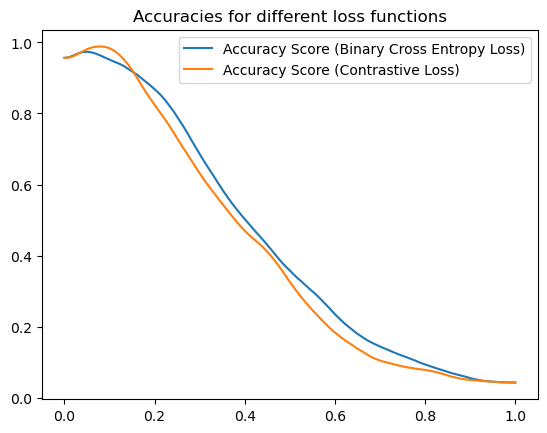

In [436]:
plt.plot(thresholds, accuracies_binary, label="Accuracy Score (Binary Cross Entropy Loss)")
plt.plot(thresholds, accuracies_contrastive, label="Accuracy Score (Contrastive Loss)")

plt.title("Accuracies for different loss functions")

plt.legend()
plt.show()